In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

from xgboost import XGBClassifier


In [3]:
train = pd.read_csv('/kaggle/input/mse-2-ai-201-b-ai-d/train.csv')


In [4]:
train['Class'] = train['Class'].fillna(train['Class'].mode()[0])

num_cols = [
    'AREA','PERIMETER','MAJOR_AXIS','MINOR_AXIS','ECCENTRICITY',
    'EQDIASQ','SOLIDITY','CONVEX_AREA','EXTENT','ASPECT_RATIO',
    'ROUNDNESS','COMPACTNESS','SHAPEFACTOR_1','SHAPEFACTOR_2',
    'SHAPEFACTOR_3','SHAPEFACTOR_4'
]

for col in num_cols:
    train[col] = train[col].fillna(train[col].median())


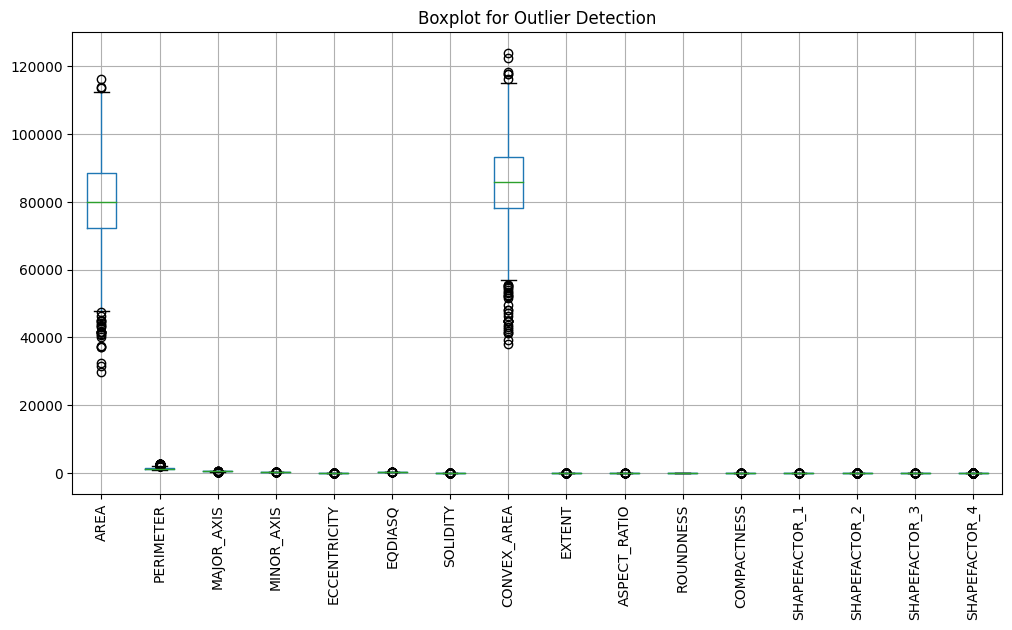

In [5]:
plt.figure(figsize=(12,6))
train[num_cols].boxplot(rot=90)
plt.title("Boxplot for Outlier Detection")
plt.show()


In [6]:
for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    train[col] = np.clip(train[col], lower, upper)


In [7]:
le = LabelEncoder()
train['Class'] = le.fit_transform(train['Class'])

X = train.drop("Class", axis=1)
y = train['Class']


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [9]:
param_dist = {
    'n_estimators': [300, 500, 800],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]
}

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier(
    objective='binary:logistic',   # 🔥 binary objective
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',   # exam friendly
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

# best model
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 0.9, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}


In [10]:
y_pred = best_model.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_pred))


Validation Accuracy: 0.8631386861313869


In [12]:


# probability of positive class (class = 1)
y_proba = best_model.predict_proba(X_val_scaled)[:, 1]

roc_auc = roc_auc_score(y_val, y_proba)

print("Binary ROC-AUC:", roc_auc)


Binary ROC-AUC: 0.9193783323256198


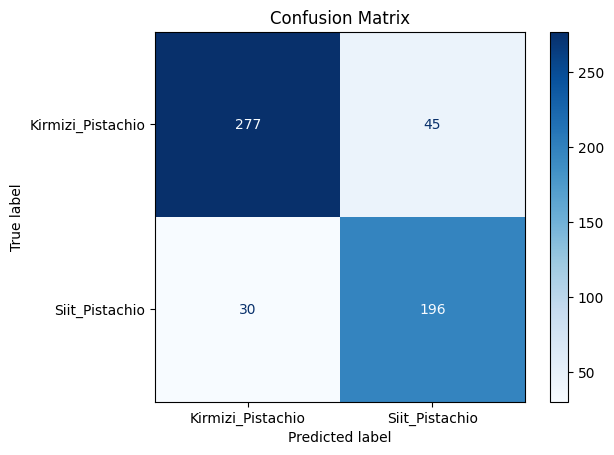

In [13]:
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [14]:
test = pd.read_csv('/kaggle/input/mse-2-ai-201-b-ai-d/test.csv')

test_ids = test['id']
test = test.drop("id", axis=1)

test_scaled = scaler.transform(test)

test_preds = best_model.predict(test_scaled)
final_preds = le.inverse_transform(test_preds)


In [15]:
submission = pd.DataFrame({
    "id": test_ids,
    "Class": final_preds
})

submission.to_csv("final_multiclass_randomsearch.csv", index=False)
